<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [1]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [3]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Constants

In [4]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_exercise_dur_agg_change',
 'other_dur_agg_change',
 'social_place_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
 'movt_agg_change',
 'wkday_total_entropy_agg_change',
 'wkend_entropy_agg_change']
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load Data

In [5]:
gad_spin_corr = pd.read_pickle("wave1_features/gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("wave1_features/phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("wave1_features/rev_phq_corr_unit.df")

# Feature Unit Weight Definitions

## Foreground Applications (fga)

- active apps: messaging, email, maps
- passive apps: chrome, youtube, browser
- social apps: orca, katana, instagram, snapchat

## Semantic Location (sloc)

- work duration: work_dur
- home duration: home_dur
- religion/exercise duration: exercise_dur, religion_dur
- social places: food, anothers_home, entertainment, shopping
- other places: other, health, errand, education

## Communication (comm)

- sms: in/out/tot_sms_count, in/out/tot_sms_length
- calls: tot_call_count, tot_call_duration

## Fused Location (fus)

- movement (movt_agg): circ_movt, cluster, dist, loc_var, velocity
- weekday entropy: norm_entropy_total/wkday, entropy_total/wkday
- weekend entropy: norm_entropy_wkend, entropy_wkend

# Plots Over Time

### PHQ

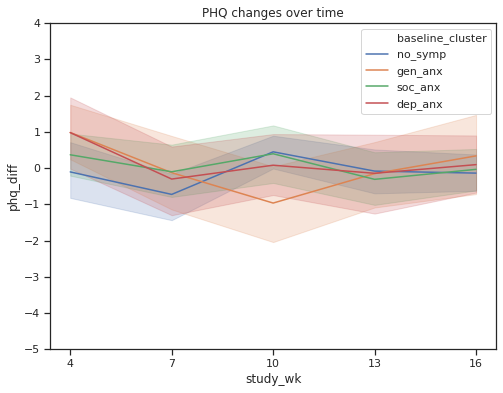

In [6]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

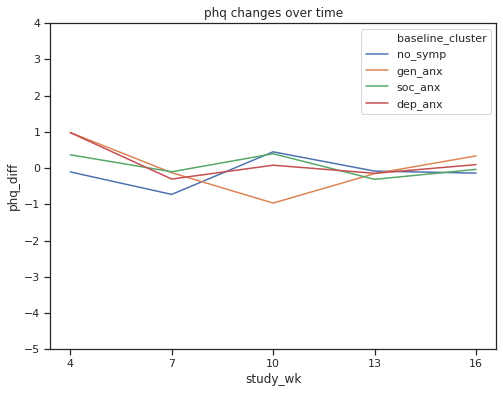

In [7]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

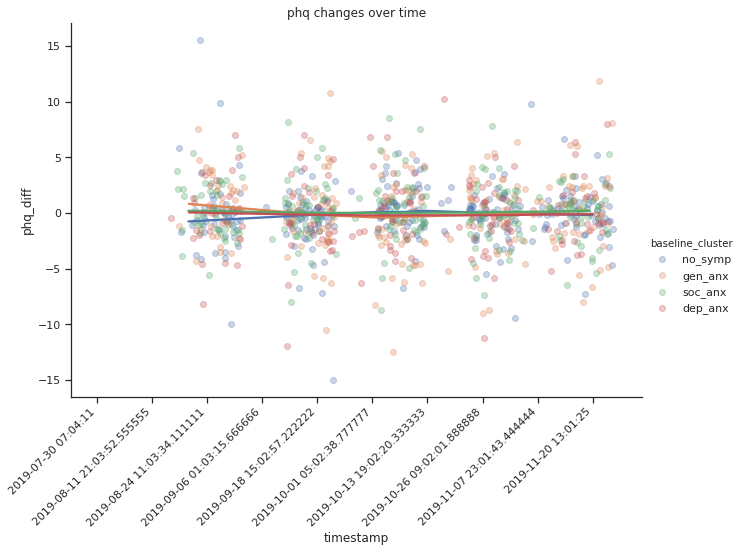

In [8]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [9]:
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

Text(0.5, 1.0, 'Within individual PHQ shift variance')

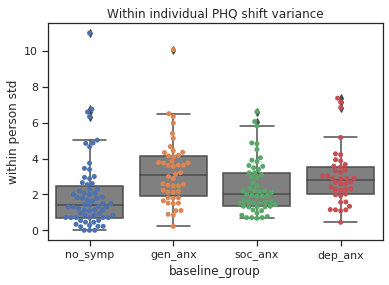

In [10]:

phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

In [11]:
phq_std.groupby('baseline_group').describe()

within person std                                          \
                           count      mean       std       min       25%   
baseline_group                                                             
dep_anx                     40.0  2.966863  1.562477  0.447214  2.009628   
gen_anx                     46.0  3.227902  1.810800  0.223607  1.892773   
no_symp                     66.0  1.992893  1.949029  0.000000  0.709545   
soc_anx                     53.0  2.428166  1.446199  0.670820  1.341641   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         2.787293  3.546078   7.368853  
gen_anx         3.065248  4.135585  10.074721  
no_symp         1.429756  2.489031  11.000000  
soc_anx         2.000000  3.209361   6.618157

### SPIN

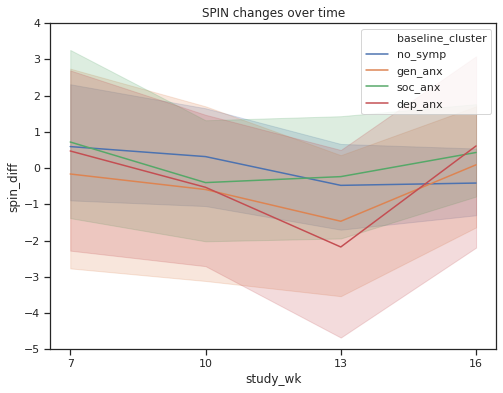

In [12]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

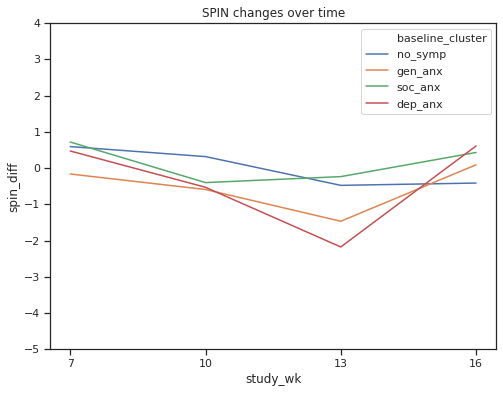

In [13]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

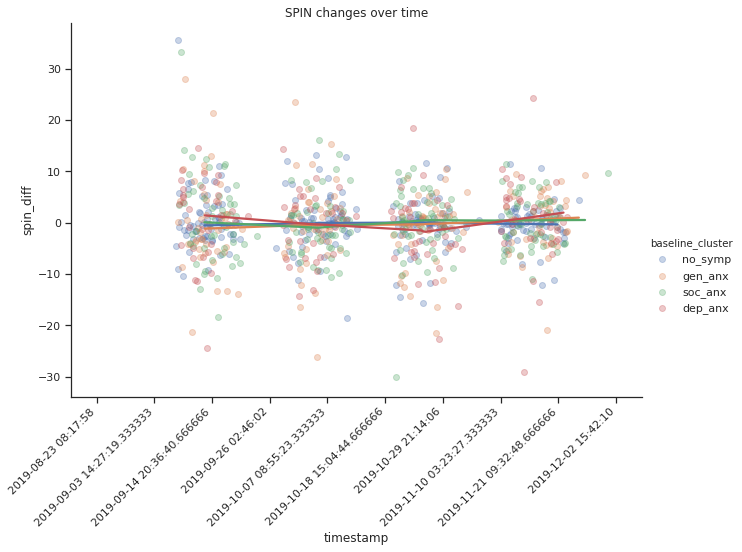

In [14]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

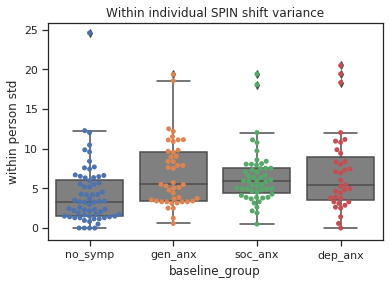

In [15]:

spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['baseline_group'] = spin_std['pid'].map(cluster_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=spin_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=spin_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [16]:
spin_std.groupby('baseline_group').describe()

within person std                                         \
                           count      mean       std      min       25%   
baseline_group                                                            
dep_anx                     35.0  6.942775  4.957938  0.00000  3.522848   
gen_anx                     44.0  6.880111  4.210229  0.57735  3.415650   
no_symp                     64.0  4.245557  3.954601  0.00000  1.500000   
soc_anx                     51.0  6.396988  3.435372  0.50000  4.386001   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         5.477226  8.908030  20.506097  
gen_anx         5.492398  9.587174  19.379972  
no_symp         3.291306  6.055021  24.608603  
soc_anx         5.909033  7.544314  19.433648

### GAD

In [17]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

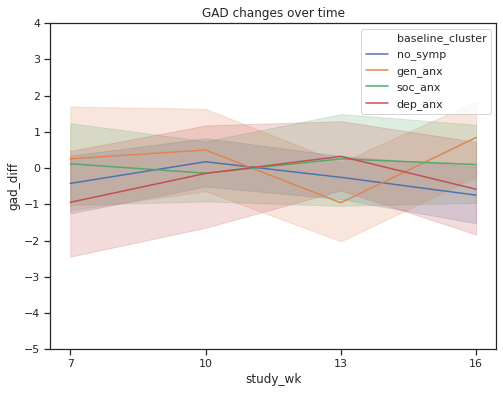

In [18]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

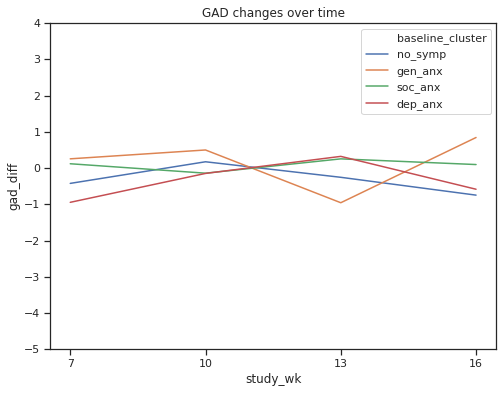

In [19]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

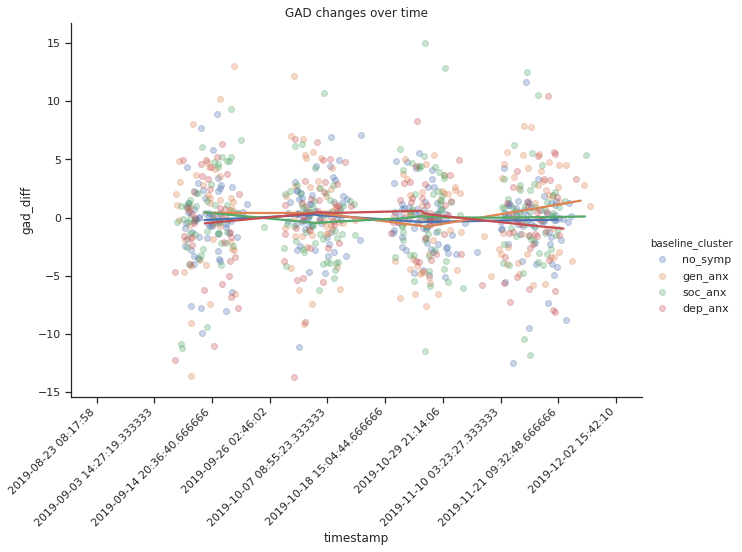

In [20]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

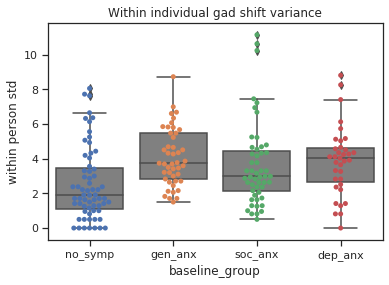

In [21]:

gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['baseline_group'] = gad_std['pid'].map(cluster_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=gad_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=gad_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual gad shift variance")

In [22]:
gad_std.groupby('baseline_group').describe()

within person std                                               \
                           count      mean       std  min       25%       50%   
baseline_group                                                                  
dep_anx                     35.0  3.862439  1.984782  0.0  2.672519  4.031129   
gen_anx                     45.0  4.084133  1.657012  1.5  2.828427  3.741657   
no_symp                     64.0  2.529825  2.110941  0.0  1.116025  1.903912   
soc_anx                     51.0  3.625552  2.433273  0.5  2.110900  2.986079   

                                     
                     75%        max  
baseline_group                       
dep_anx         4.614110   8.812869  
gen_anx         5.477226   8.732125  
no_symp         3.442329   8.057088  
soc_anx         4.447695  11.150486

# SPIN

## Full population

In [23]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,767,0.008,0.8302,0.8302,fdr_bh
1,passive_apps_agg_change,spin_diff,767,0.104,0.0038*,0.0245*,fdr_bh
2,social_apps_agg_change,spin_diff,767,-0.012,0.7400,0.8302,fdr_bh
3,work_dur_agg_change,spin_diff,763,-0.011,0.7519,0.8302,fdr_bh
4,home_dur_agg_change,spin_diff,763,0.026,0.4674,0.8302,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,763,0.009,0.8033,0.8302,fdr_bh
6,other_dur_agg_change,spin_diff,763,0.032,0.3787,0.8300,fdr_bh
7,social_place_dur_agg_change,spin_diff,763,-0.117,0.0012*,0.0159*,fdr_bh
8,sms_agg_change,spin_diff,744,-0.052,0.1601,0.6937,fdr_bh
9,cal_agg_change,spin_diff,757,0.013,0.7300,0.8302,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,767,-0.001,0.9791,0.9791,fdr_bh
1,passive_apps_agg_change,spin_diff,767,0.115,0.0014*,0.0187*,fdr_bh
2,social_apps_agg_change,spin_diff,767,0.011,0.7676,0.8316,fdr_bh
3,work_dur_agg_change,spin_diff,763,-0.019,0.6098,0.7207,fdr_bh
4,home_dur_agg_change,spin_diff,763,0.021,0.5544,0.7207,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,763,0.02,0.5746,0.7207,fdr_bh
6,other_dur_agg_change,spin_diff,763,0.068,0.0603*,0.2485,fdr_bh
7,social_place_dur_agg_change,spin_diff,763,-0.064,0.0765*,0.2485,fdr_bh
8,sms_agg_change,spin_diff,744,-0.07,0.0565*,0.2485,fdr_bh
9,cal_agg_change,spin_diff,757,-0.03,0.4078,0.7207,fdr_bh


## no_symp

In [24]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,0.025,0.6945,0.9755,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.092,0.1436,0.7033,fdr_bh
2,social_apps_agg_change,spin_diff,252,-0.002,0.9755,0.9755,fdr_bh
3,work_dur_agg_change,spin_diff,252,-0.045,0.4749,0.9755,fdr_bh
4,home_dur_agg_change,spin_diff,252,0.011,0.8657,0.9755,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,252,-0.011,0.8590,0.9755,fdr_bh
6,other_dur_agg_change,spin_diff,252,-0.033,0.6056,0.9755,fdr_bh
7,social_place_dur_agg_change,spin_diff,252,-0.09,0.1557,0.7033,fdr_bh
8,sms_agg_change,spin_diff,247,-0.089,0.1623,0.7033,fdr_bh
9,cal_agg_change,spin_diff,252,-0.004,0.9551,0.9755,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,0.059,0.3478,0.8943,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.124,0.0498*,0.6472,fdr_bh
2,social_apps_agg_change,spin_diff,252,0.05,0.4258,0.8943,fdr_bh
3,work_dur_agg_change,spin_diff,252,-0.052,0.4147,0.8943,fdr_bh
4,home_dur_agg_change,spin_diff,252,0.066,0.2950,0.8943,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,252,-0.014,0.8233,0.9962,fdr_bh
6,other_dur_agg_change,spin_diff,252,0.004,0.9508,0.9962,fdr_bh
7,social_place_dur_agg_change,spin_diff,252,-0.096,0.1294,0.8409,fdr_bh
8,sms_agg_change,spin_diff,247,-0.03,0.6338,0.9962,fdr_bh
9,cal_agg_change,spin_diff,252,-0.045,0.4816,0.8943,fdr_bh


## soc_anx

In [25]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,202,0.05,0.4792,0.8246,fdr_bh
1,passive_apps_agg_change,spin_diff,202,0.224,0.0014*,0.0090*,fdr_bh
2,social_apps_agg_change,spin_diff,202,-0.004,0.9497,0.9497,fdr_bh
3,work_dur_agg_change,spin_diff,202,0.023,0.7411,0.8758,fdr_bh
4,home_dur_agg_change,spin_diff,202,0.031,0.6587,0.8563,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,202,0.047,0.5075,0.8246,fdr_bh
6,other_dur_agg_change,spin_diff,202,0.069,0.3297,0.8246,fdr_bh
7,social_place_dur_agg_change,spin_diff,202,-0.263,0.0002*,0.0020*,fdr_bh
8,sms_agg_change,spin_diff,202,0.016,0.8206,0.8889,fdr_bh
9,cal_agg_change,spin_diff,202,0.13,0.0661*,0.2863,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,202,0.022,0.7604,0.8626,fdr_bh
1,passive_apps_agg_change,spin_diff,202,0.195,0.0054*,0.0707*,fdr_bh
2,social_apps_agg_change,spin_diff,202,0.027,0.7079,0.8626,fdr_bh
3,work_dur_agg_change,spin_diff,202,0.003,0.9683,0.9683,fdr_bh
4,home_dur_agg_change,spin_diff,202,0.06,0.3974,0.8611,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,202,0.068,0.3347,0.8611,fdr_bh
6,other_dur_agg_change,spin_diff,202,0.174,0.0133*,0.0866*,fdr_bh
7,social_place_dur_agg_change,spin_diff,202,-0.122,0.0837*,0.3628,fdr_bh
8,sms_agg_change,spin_diff,202,-0.018,0.7963,0.8626,fdr_bh
9,cal_agg_change,spin_diff,202,0.019,0.7870,0.8626,fdr_bh


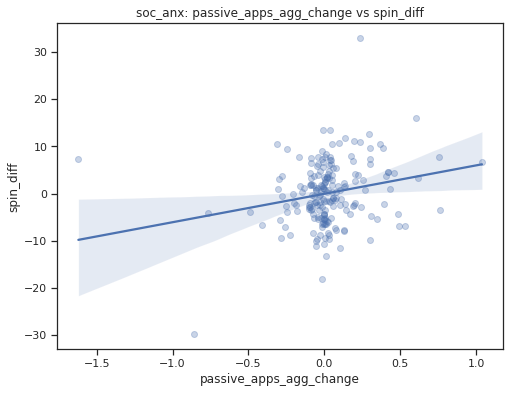

In [26]:
ls_utils.plot_cluster_scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

## gen_anx

In [27]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,175,-0.096,0.2084,0.9030,fdr_bh
1,passive_apps_agg_change,spin_diff,175,0.011,0.8883,0.9375,fdr_bh
2,social_apps_agg_change,spin_diff,175,-0.036,0.6356,0.9375,fdr_bh
3,work_dur_agg_change,spin_diff,174,-0.02,0.7914,0.9375,fdr_bh
4,home_dur_agg_change,spin_diff,174,-0.029,0.7084,0.9375,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,174,0.04,0.6040,0.9375,fdr_bh
6,other_dur_agg_change,spin_diff,174,0.035,0.6488,0.9375,fdr_bh
7,social_place_dur_agg_change,spin_diff,174,0.016,0.8315,0.9375,fdr_bh
8,sms_agg_change,spin_diff,168,-0.084,0.2785,0.9053,fdr_bh
9,cal_agg_change,spin_diff,173,-0.102,0.1798,0.9030,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,175,-0.114,0.1340,0.4373,fdr_bh
1,passive_apps_agg_change,spin_diff,175,0.114,0.1346,0.4373,fdr_bh
2,social_apps_agg_change,spin_diff,175,-0.033,0.6686,0.8176,fdr_bh
3,work_dur_agg_change,spin_diff,174,-0.017,0.8262,0.8951,fdr_bh
4,home_dur_agg_change,spin_diff,174,-0.07,0.3609,0.6702,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,174,0.034,0.6600,0.8176,fdr_bh
6,other_dur_agg_change,spin_diff,174,0.009,0.9026,0.9026,fdr_bh
7,social_place_dur_agg_change,spin_diff,174,0.031,0.6848,0.8176,fdr_bh
8,sms_agg_change,spin_diff,168,-0.134,0.0841*,0.4373,fdr_bh
9,cal_agg_change,spin_diff,173,-0.118,0.1235,0.4373,fdr_bh


## dep_anx

In [28]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,138,0.052,0.5415,0.7626,fdr_bh
1,passive_apps_agg_change,spin_diff,138,0.144,0.0916*,0.7066,fdr_bh
2,social_apps_agg_change,spin_diff,138,-0.014,0.8664,0.9327,fdr_bh
3,work_dur_agg_change,spin_diff,135,0.007,0.9327,0.9327,fdr_bh
4,home_dur_agg_change,spin_diff,135,0.108,0.2124,0.7066,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,135,-0.069,0.4277,0.7100,fdr_bh
6,other_dur_agg_change,spin_diff,135,0.092,0.2882,0.7066,fdr_bh
7,social_place_dur_agg_change,spin_diff,135,-0.105,0.2255,0.7066,fdr_bh
8,sms_agg_change,spin_diff,127,-0.088,0.3261,0.7066,fdr_bh
9,cal_agg_change,spin_diff,130,-0.129,0.1430,0.7066,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,138,0.036,0.6784,0.9951,fdr_bh
1,passive_apps_agg_change,spin_diff,138,0.012,0.8886,0.9951,fdr_bh
2,social_apps_agg_change,spin_diff,138,0.002,0.9803,0.9951,fdr_bh
3,work_dur_agg_change,spin_diff,135,-0.011,0.8977,0.9951,fdr_bh
4,home_dur_agg_change,spin_diff,135,0.028,0.7470,0.9951,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,135,-0.034,0.6997,0.9951,fdr_bh
6,other_dur_agg_change,spin_diff,135,0.07,0.4170,0.9951,fdr_bh
7,social_place_dur_agg_change,spin_diff,135,-0.06,0.4887,0.9951,fdr_bh
8,sms_agg_change,spin_diff,127,-0.135,0.1306,0.9951,fdr_bh
9,cal_agg_change,spin_diff,130,0.025,0.7814,0.9951,fdr_bh


# Reverse SPIN

## Full population

In [29]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,764,0.083,0.0211*,0.2744,fdr_bh
1,passive_apps_agg_change,spin_diff,764,0.014,0.7057,0.7645,fdr_bh
2,social_apps_agg_change,spin_diff,764,0.019,0.5955,0.7645,fdr_bh
3,work_dur_agg_change,spin_diff,762,0.004,0.9215,0.9215,fdr_bh
4,home_dur_agg_change,spin_diff,762,0.03,0.4038,0.6573,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,762,0.03,0.4045,0.6573,fdr_bh
6,other_dur_agg_change,spin_diff,762,0.065,0.0726*,0.2888,fdr_bh
7,social_place_dur_agg_change,spin_diff,762,0.057,0.1177,0.3059,fdr_bh
8,sms_agg_change,spin_diff,740,0.045,0.2222,0.4815,fdr_bh
9,cal_agg_change,spin_diff,749,-0.019,0.6020,0.7645,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,764,0.06,0.0960*,0.2496,fdr_bh
1,passive_apps_agg_change,spin_diff,764,-0.015,0.6725,0.8743,fdr_bh
2,social_apps_agg_change,spin_diff,764,0.064,0.0776*,0.2496,fdr_bh
3,work_dur_agg_change,spin_diff,762,0.035,0.3355,0.5863,fdr_bh
4,home_dur_agg_change,spin_diff,762,0.033,0.3608,0.5863,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,762,0.008,0.8175,0.8937,fdr_bh
6,other_dur_agg_change,spin_diff,762,0.097,0.0072*,0.0930*,fdr_bh
7,social_place_dur_agg_change,spin_diff,762,0.039,0.2865,0.5863,fdr_bh
8,sms_agg_change,spin_diff,740,-0.002,0.9623,0.9623,fdr_bh
9,cal_agg_change,spin_diff,749,0.017,0.6372,0.8743,fdr_bh


## no_symp

In [30]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,0.013,0.8357,0.8357,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.014,0.8194,0.8357,fdr_bh
2,social_apps_agg_change,spin_diff,252,0.035,0.5768,0.8357,fdr_bh
3,work_dur_agg_change,spin_diff,252,0.04,0.5321,0.8357,fdr_bh
4,home_dur_agg_change,spin_diff,252,0.024,0.6994,0.8357,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,252,-0.022,0.7262,0.8357,fdr_bh
6,other_dur_agg_change,spin_diff,252,0.105,0.0967*,0.4188,fdr_bh
7,social_place_dur_agg_change,spin_diff,252,0.131,0.0379*,0.3346,fdr_bh
8,sms_agg_change,spin_diff,248,0.054,0.3974,0.8357,fdr_bh
9,cal_agg_change,spin_diff,252,0.056,0.3782,0.8357,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,0.007,0.9129,0.9890,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.03,0.6379,0.9890,fdr_bh
2,social_apps_agg_change,spin_diff,252,0.117,0.0628*,0.2245,fdr_bh
3,work_dur_agg_change,spin_diff,252,0.027,0.6685,0.9890,fdr_bh
4,home_dur_agg_change,spin_diff,252,0.009,0.8818,0.9890,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,252,-0.03,0.6307,0.9890,fdr_bh
6,other_dur_agg_change,spin_diff,252,0.073,0.2482,0.6453,fdr_bh
7,social_place_dur_agg_change,spin_diff,252,0.118,0.0619*,0.2245,fdr_bh
8,sms_agg_change,spin_diff,248,-0.018,0.7724,0.9890,fdr_bh
9,cal_agg_change,spin_diff,252,0.024,0.7017,0.9890,fdr_bh


## soc_anx

In [31]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,201,0.157,0.0264*,0.1633,fdr_bh
1,passive_apps_agg_change,spin_diff,201,-0.065,0.3625,0.6353,fdr_bh
2,social_apps_agg_change,spin_diff,201,0.01,0.8899,0.8899,fdr_bh
3,work_dur_agg_change,spin_diff,201,-0.039,0.5865,0.6353,fdr_bh
4,home_dur_agg_change,spin_diff,201,0.042,0.5555,0.6353,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,201,0.2,0.0044*,0.0576*,fdr_bh
6,other_dur_agg_change,spin_diff,201,0.046,0.5131,0.6353,fdr_bh
7,social_place_dur_agg_change,spin_diff,201,0.056,0.4301,0.6353,fdr_bh
8,sms_agg_change,spin_diff,200,0.071,0.3210,0.6353,fdr_bh
9,cal_agg_change,spin_diff,200,-0.067,0.3441,0.6353,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,201,0.127,0.0716*,0.3102,fdr_bh
1,passive_apps_agg_change,spin_diff,201,-0.087,0.2198,0.5343,fdr_bh
2,social_apps_agg_change,spin_diff,201,0.043,0.5454,0.7090,fdr_bh
3,work_dur_agg_change,spin_diff,201,0.043,0.5427,0.7090,fdr_bh
4,home_dur_agg_change,spin_diff,201,0.061,0.3869,0.6287,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,201,0.129,0.0676*,0.3102,fdr_bh
6,other_dur_agg_change,spin_diff,201,0.156,0.0266*,0.3102,fdr_bh
7,social_place_dur_agg_change,spin_diff,201,0.021,0.7702,0.8344,fdr_bh
8,sms_agg_change,spin_diff,200,-0.005,0.9407,0.9407,fdr_bh
9,cal_agg_change,spin_diff,200,-0.023,0.7462,0.8344,fdr_bh


## gen_anx

In [32]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,174,0.103,0.1745,0.9781,fdr_bh
1,passive_apps_agg_change,spin_diff,174,0.047,0.5384,0.9781,fdr_bh
2,social_apps_agg_change,spin_diff,174,-0.029,0.6994,0.9781,fdr_bh
3,work_dur_agg_change,spin_diff,174,-0.002,0.9781,0.9781,fdr_bh
4,home_dur_agg_change,spin_diff,174,0.066,0.3853,0.9781,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,174,-0.029,0.7078,0.9781,fdr_bh
6,other_dur_agg_change,spin_diff,174,0.066,0.3853,0.9781,fdr_bh
7,social_place_dur_agg_change,spin_diff,174,0.006,0.9356,0.9781,fdr_bh
8,sms_agg_change,spin_diff,166,0.014,0.8551,0.9781,fdr_bh
9,cal_agg_change,spin_diff,169,-0.058,0.4520,0.9781,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,174,0.08,0.2969,0.8167,fdr_bh
1,passive_apps_agg_change,spin_diff,174,-0.023,0.7621,0.9379,fdr_bh
2,social_apps_agg_change,spin_diff,174,0.051,0.5046,0.8167,fdr_bh
3,work_dur_agg_change,spin_diff,174,0.056,0.4616,0.8167,fdr_bh
4,home_dur_agg_change,spin_diff,174,0.05,0.5108,0.8167,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,174,-0.125,0.1014,0.8167,fdr_bh
6,other_dur_agg_change,spin_diff,174,0.088,0.2482,0.8167,fdr_bh
7,social_place_dur_agg_change,spin_diff,174,-0.008,0.9116,0.9379,fdr_bh
8,sms_agg_change,spin_diff,166,0.018,0.8217,0.9379,fdr_bh
9,cal_agg_change,spin_diff,169,0.045,0.5654,0.8167,fdr_bh


## dep_anx

In [33]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,137,0.044,0.6098,0.9463,fdr_bh
1,passive_apps_agg_change,spin_diff,137,0.075,0.3852,0.9463,fdr_bh
2,social_apps_agg_change,spin_diff,137,0.061,0.4764,0.9463,fdr_bh
3,work_dur_agg_change,spin_diff,135,0.017,0.8415,0.9463,fdr_bh
4,home_dur_agg_change,spin_diff,135,-0.023,0.7917,0.9463,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,135,0.006,0.9463,0.9463,fdr_bh
6,other_dur_agg_change,spin_diff,135,0.056,0.5161,0.9463,fdr_bh
7,social_place_dur_agg_change,spin_diff,135,-0.008,0.9279,0.9463,fdr_bh
8,sms_agg_change,spin_diff,126,0.022,0.8068,0.9463,fdr_bh
9,cal_agg_change,spin_diff,128,0.071,0.4262,0.9463,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,137,0.031,0.7197,0.9298,fdr_bh
1,passive_apps_agg_change,spin_diff,137,0.072,0.4047,0.9298,fdr_bh
2,social_apps_agg_change,spin_diff,137,0.071,0.4089,0.9298,fdr_bh
3,work_dur_agg_change,spin_diff,135,-0.016,0.8583,0.9298,fdr_bh
4,home_dur_agg_change,spin_diff,135,0.019,0.8282,0.9298,fdr_bh
5,religion_exercise_dur_agg_change,spin_diff,135,0.047,0.5894,0.9298,fdr_bh
6,other_dur_agg_change,spin_diff,135,0.042,0.6289,0.9298,fdr_bh
7,social_place_dur_agg_change,spin_diff,135,-0.022,0.7958,0.9298,fdr_bh
8,sms_agg_change,spin_diff,126,0.041,0.6482,0.9298,fdr_bh
9,cal_agg_change,spin_diff,128,0.024,0.7882,0.9298,fdr_bh


# GAD

## Full population

In [34]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,768,0.071,0.0500*,0.2165,fdr_bh
1,passive_apps_agg_change,gad_diff,768,0.055,0.1257,0.3267,fdr_bh
2,social_apps_agg_change,gad_diff,768,-0.009,0.7980,0.9430,fdr_bh
3,work_dur_agg_change,gad_diff,764,0.042,0.2483,0.4036,fdr_bh
4,home_dur_agg_change,gad_diff,764,-0,0.9937,0.9937,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,764,0.06,0.0957*,0.3109,fdr_bh
6,other_dur_agg_change,gad_diff,764,0.013,0.7298,0.9430,fdr_bh
7,social_place_dur_agg_change,gad_diff,764,-0.078,0.0316*,0.2165,fdr_bh
8,sms_agg_change,gad_diff,745,0.049,0.1795,0.3888,fdr_bh
9,cal_agg_change,gad_diff,758,0.075,0.0391*,0.2165,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,768,0.1,0.0054*,0.0350*,fdr_bh
1,passive_apps_agg_change,gad_diff,768,0.052,0.1483,0.3213,fdr_bh
2,social_apps_agg_change,gad_diff,768,-0.062,0.0856*,0.2225,fdr_bh
3,work_dur_agg_change,gad_diff,764,0.024,0.4996,0.7217,fdr_bh
4,home_dur_agg_change,gad_diff,764,-0.009,0.7935,0.8781,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,764,0.032,0.3701,0.6014,fdr_bh
6,other_dur_agg_change,gad_diff,764,-0.007,0.8459,0.8781,fdr_bh
7,social_place_dur_agg_change,gad_diff,764,-0.036,0.3150,0.5851,fdr_bh
8,sms_agg_change,gad_diff,745,0.081,0.0265*,0.0869*,fdr_bh
9,cal_agg_change,gad_diff,758,0.114,0.0017*,0.0225*,fdr_bh


## no_symp

In [35]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,252,0,0.9949,0.9949,fdr_bh
1,passive_apps_agg_change,gad_diff,252,0.083,0.1914,0.4977,fdr_bh
2,social_apps_agg_change,gad_diff,252,0.119,0.0603*,0.3918,fdr_bh
3,work_dur_agg_change,gad_diff,252,0.017,0.7851,0.8505,fdr_bh
4,home_dur_agg_change,gad_diff,252,0.126,0.0450*,0.3918,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,252,0.058,0.3610,0.6499,fdr_bh
6,other_dur_agg_change,gad_diff,252,0.023,0.7165,0.8467,fdr_bh
7,social_place_dur_agg_change,gad_diff,252,-0.053,0.4054,0.6499,fdr_bh
8,sms_agg_change,gad_diff,247,0.054,0.3984,0.6499,fdr_bh
9,cal_agg_change,gad_diff,252,0.085,0.1787,0.4977,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,252,0.017,0.7831,0.8149,fdr_bh
1,passive_apps_agg_change,gad_diff,252,0.109,0.0840*,0.3777,fdr_bh
2,social_apps_agg_change,gad_diff,252,0.078,0.2164,0.6046,fdr_bh
3,work_dur_agg_change,gad_diff,252,-0.034,0.5895,0.8149,fdr_bh
4,home_dur_agg_change,gad_diff,252,0.045,0.4809,0.7815,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,252,0.065,0.3075,0.6046,fdr_bh
6,other_dur_agg_change,gad_diff,252,0.027,0.6727,0.8149,fdr_bh
7,social_place_dur_agg_change,gad_diff,252,-0.017,0.7875,0.8149,fdr_bh
8,sms_agg_change,gad_diff,247,0.109,0.0872*,0.3777,fdr_bh
9,cal_agg_change,gad_diff,252,0.129,0.0413*,0.3777,fdr_bh


## soc_anx

In [36]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,202,0.145,0.0401*,0.5219,fdr_bh
1,passive_apps_agg_change,gad_diff,202,0.093,0.1868,0.8096,fdr_bh
2,social_apps_agg_change,gad_diff,202,-0.051,0.4685,0.9497,fdr_bh
3,work_dur_agg_change,gad_diff,202,-0.021,0.7618,0.9497,fdr_bh
4,home_dur_agg_change,gad_diff,202,-0.009,0.9018,0.9497,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,202,-0.004,0.9497,0.9497,fdr_bh
6,other_dur_agg_change,gad_diff,202,0.05,0.4825,0.9497,fdr_bh
7,social_place_dur_agg_change,gad_diff,202,-0.042,0.5499,0.9497,fdr_bh
8,sms_agg_change,gad_diff,202,0.062,0.3825,0.9497,fdr_bh
9,cal_agg_change,gad_diff,202,0.098,0.1670,0.8096,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,202,0.199,0.0045*,0.0586*,fdr_bh
1,passive_apps_agg_change,gad_diff,202,0.084,0.2357,0.7661,fdr_bh
2,social_apps_agg_change,gad_diff,202,-0.025,0.7243,0.9416,fdr_bh
3,work_dur_agg_change,gad_diff,202,-0.037,0.6049,0.9416,fdr_bh
4,home_dur_agg_change,gad_diff,202,0.005,0.9436,0.9436,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,202,-0.034,0.6293,0.9416,fdr_bh
6,other_dur_agg_change,gad_diff,202,0.056,0.4254,0.9416,fdr_bh
7,social_place_dur_agg_change,gad_diff,202,0.005,0.9435,0.9436,fdr_bh
8,sms_agg_change,gad_diff,202,0.115,0.1045,0.4529,fdr_bh
9,cal_agg_change,gad_diff,202,0.154,0.0281*,0.1829,fdr_bh


## gen_anx

In [37]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,176,0.181,0.0164*,0.1813,fdr_bh
1,passive_apps_agg_change,gad_diff,176,0.032,0.6763,0.8792,fdr_bh
2,social_apps_agg_change,gad_diff,176,-0.018,0.8161,0.9278,fdr_bh
3,work_dur_agg_change,gad_diff,175,0.096,0.2085,0.4518,fdr_bh
4,home_dur_agg_change,gad_diff,175,-0.114,0.1329,0.3707,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,175,0.111,0.1426,0.3707,fdr_bh
6,other_dur_agg_change,gad_diff,175,0.014,0.8564,0.9278,fdr_bh
7,social_place_dur_agg_change,gad_diff,175,-0.07,0.3595,0.5842,fdr_bh
8,sms_agg_change,gad_diff,169,0.169,0.0279*,0.1813,fdr_bh
9,cal_agg_change,gad_diff,174,0.083,0.2751,0.5108,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,176,0.24,0.0013*,0.0170*,fdr_bh
1,passive_apps_agg_change,gad_diff,176,0.025,0.7393,0.8737,fdr_bh
2,social_apps_agg_change,gad_diff,176,-0.057,0.4560,0.6587,fdr_bh
3,work_dur_agg_change,gad_diff,175,0.147,0.0527*,0.2149,fdr_bh
4,home_dur_agg_change,gad_diff,175,-0.078,0.3049,0.5643,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,175,0.002,0.9745,0.9745,fdr_bh
6,other_dur_agg_change,gad_diff,175,-0.046,0.5413,0.7037,fdr_bh
7,social_place_dur_agg_change,gad_diff,175,-0.102,0.1781,0.3858,fdr_bh
8,sms_agg_change,gad_diff,169,0.134,0.0827*,0.2149,fdr_bh
9,cal_agg_change,gad_diff,174,0.139,0.0683*,0.2149,fdr_bh


## dep_anx

In [38]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,138,-0.1,0.2426,0.6308,fdr_bh
1,passive_apps_agg_change,gad_diff,138,0.01,0.9082,0.9839,fdr_bh
2,social_apps_agg_change,gad_diff,138,-0.136,0.1105,0.3590,fdr_bh
3,work_dur_agg_change,gad_diff,135,0.088,0.3122,0.6764,fdr_bh
4,home_dur_agg_change,gad_diff,135,-0.028,0.7487,0.9714,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,135,0.145,0.0938*,0.3590,fdr_bh
6,other_dur_agg_change,gad_diff,135,-0.067,0.4376,0.8126,fdr_bh
7,social_place_dur_agg_change,gad_diff,135,-0.149,0.0848*,0.3590,fdr_bh
8,sms_agg_change,gad_diff,127,-0.054,0.5477,0.8899,fdr_bh
9,cal_agg_change,gad_diff,130,0.023,0.7935,0.9714,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,138,-0.067,0.4325,0.8137,fdr_bh
1,passive_apps_agg_change,gad_diff,138,-0.03,0.7282,0.8872,fdr_bh
2,social_apps_agg_change,gad_diff,138,-0.259,0.0022*,0.0283*,fdr_bh
3,work_dur_agg_change,gad_diff,135,0.003,0.9754,0.9754,fdr_bh
4,home_dur_agg_change,gad_diff,135,-0.028,0.7507,0.8872,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,135,0.075,0.3890,0.8137,fdr_bh
6,other_dur_agg_change,gad_diff,135,-0.081,0.3520,0.8137,fdr_bh
7,social_place_dur_agg_change,gad_diff,135,-0.055,0.5232,0.8137,fdr_bh
8,sms_agg_change,gad_diff,127,-0.075,0.4033,0.8137,fdr_bh
9,cal_agg_change,gad_diff,130,0.009,0.9194,0.9754,fdr_bh


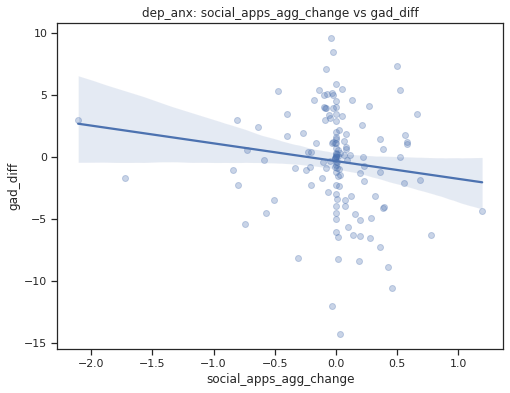

In [39]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', gad_spin_corr, 'dep_anx', (8,6))

# Reverse GAD

## Full population

In [40]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,764,0.009,0.8124,0.9601,fdr_bh
1,passive_apps_agg_change,gad_diff,764,0.001,0.9845,0.9845,fdr_bh
2,social_apps_agg_change,gad_diff,764,0.043,0.2312,0.9601,fdr_bh
3,work_dur_agg_change,gad_diff,762,-0.037,0.3130,0.9601,fdr_bh
4,home_dur_agg_change,gad_diff,762,-0.012,0.7500,0.9601,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,762,0.009,0.8070,0.9601,fdr_bh
6,other_dur_agg_change,gad_diff,762,-0.012,0.7309,0.9601,fdr_bh
7,social_place_dur_agg_change,gad_diff,762,0.027,0.4519,0.9601,fdr_bh
8,sms_agg_change,gad_diff,740,-0.029,0.4269,0.9601,fdr_bh
9,cal_agg_change,gad_diff,749,-0.003,0.9419,0.9845,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,764,0.006,0.8668,0.9569,fdr_bh
1,passive_apps_agg_change,gad_diff,764,-0.013,0.7251,0.9569,fdr_bh
2,social_apps_agg_change,gad_diff,764,0.059,0.1030,0.8454,fdr_bh
3,work_dur_agg_change,gad_diff,762,-0.009,0.7962,0.9569,fdr_bh
4,home_dur_agg_change,gad_diff,762,-0.023,0.5222,0.9569,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,762,0.005,0.8833,0.9569,fdr_bh
6,other_dur_agg_change,gad_diff,762,0.002,0.9634,0.9634,fdr_bh
7,social_place_dur_agg_change,gad_diff,762,0.038,0.2946,0.8454,fdr_bh
8,sms_agg_change,gad_diff,740,-0.009,0.8091,0.9569,fdr_bh
9,cal_agg_change,gad_diff,749,0.031,0.3902,0.8454,fdr_bh


## no_symp

In [41]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,252,0.067,0.2914,0.9709,fdr_bh
1,passive_apps_agg_change,gad_diff,252,0.025,0.6943,0.9709,fdr_bh
2,social_apps_agg_change,gad_diff,252,-0.004,0.9512,0.9709,fdr_bh
3,work_dur_agg_change,gad_diff,252,-0.017,0.7932,0.9709,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.002,0.9709,0.9709,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,252,-0.008,0.8941,0.9709,fdr_bh
6,other_dur_agg_change,gad_diff,252,-0.045,0.4784,0.9709,fdr_bh
7,social_place_dur_agg_change,gad_diff,252,0.019,0.7597,0.9709,fdr_bh
8,sms_agg_change,gad_diff,248,-0.131,0.0386*,0.2511,fdr_bh
9,cal_agg_change,gad_diff,252,0.054,0.3932,0.9709,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,252,0.057,0.3684,0.9041,fdr_bh
1,passive_apps_agg_change,gad_diff,252,-0.05,0.4315,0.9041,fdr_bh
2,social_apps_agg_change,gad_diff,252,-0.023,0.7186,0.9272,fdr_bh
3,work_dur_agg_change,gad_diff,252,-0.005,0.9329,0.9329,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.031,0.6259,0.9041,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,252,0.035,0.5755,0.9041,fdr_bh
6,other_dur_agg_change,gad_diff,252,0.037,0.5629,0.9041,fdr_bh
7,social_place_dur_agg_change,gad_diff,252,0.007,0.9105,0.9329,fdr_bh
8,sms_agg_change,gad_diff,248,-0.041,0.5210,0.9041,fdr_bh
9,cal_agg_change,gad_diff,252,0.09,0.1526,0.9041,fdr_bh


## soc_anx

In [42]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,201,-0.05,0.4815,0.9526,fdr_bh
1,passive_apps_agg_change,gad_diff,201,0.003,0.9656,0.9790,fdr_bh
2,social_apps_agg_change,gad_diff,201,0.062,0.3817,0.9526,fdr_bh
3,work_dur_agg_change,gad_diff,201,0.038,0.5936,0.9526,fdr_bh
4,home_dur_agg_change,gad_diff,201,0.051,0.4702,0.9526,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,201,0.062,0.3836,0.9526,fdr_bh
6,other_dur_agg_change,gad_diff,201,0.031,0.6595,0.9526,fdr_bh
7,social_place_dur_agg_change,gad_diff,201,0.158,0.0246*,0.3204,fdr_bh
8,sms_agg_change,gad_diff,200,-0.042,0.5572,0.9526,fdr_bh
9,cal_agg_change,gad_diff,200,0.07,0.3259,0.9526,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,201,-0.093,0.1911,0.4969,fdr_bh
1,passive_apps_agg_change,gad_diff,201,-0.014,0.8391,0.8391,fdr_bh
2,social_apps_agg_change,gad_diff,201,0.123,0.0813*,0.4028,fdr_bh
3,work_dur_agg_change,gad_diff,201,0.061,0.3876,0.5997,fdr_bh
4,home_dur_agg_change,gad_diff,201,0.067,0.3422,0.5997,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,201,0.109,0.1239,0.4028,fdr_bh
6,other_dur_agg_change,gad_diff,201,0.118,0.0948*,0.4028,fdr_bh
7,social_place_dur_agg_change,gad_diff,201,0.171,0.0149*,0.1942,fdr_bh
8,sms_agg_change,gad_diff,200,-0.058,0.4152,0.5997,fdr_bh
9,cal_agg_change,gad_diff,200,-0.021,0.7673,0.8312,fdr_bh


## gen_anx

In [43]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,174,-0.005,0.9437,0.9839,fdr_bh
1,passive_apps_agg_change,gad_diff,174,0.012,0.8783,0.9839,fdr_bh
2,social_apps_agg_change,gad_diff,174,0.057,0.4547,0.9588,fdr_bh
3,work_dur_agg_change,gad_diff,174,-0.114,0.1347,0.6288,fdr_bh
4,home_dur_agg_change,gad_diff,174,-0.061,0.4218,0.9588,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,174,0.004,0.9580,0.9839,fdr_bh
6,other_dur_agg_change,gad_diff,174,-0.01,0.8942,0.9839,fdr_bh
7,social_place_dur_agg_change,gad_diff,174,-0.05,0.5163,0.9588,fdr_bh
8,sms_agg_change,gad_diff,166,0.118,0.1291,0.6288,fdr_bh
9,cal_agg_change,gad_diff,169,-0.031,0.6872,0.9839,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,174,-0.018,0.8186,0.8876,fdr_bh
1,passive_apps_agg_change,gad_diff,174,0.083,0.2787,0.6387,fdr_bh
2,social_apps_agg_change,gad_diff,174,0.107,0.1588,0.5160,fdr_bh
3,work_dur_agg_change,gad_diff,174,-0.11,0.1473,0.5160,fdr_bh
4,home_dur_agg_change,gad_diff,174,-0.04,0.6015,0.7820,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,174,-0.147,0.0535*,0.5160,fdr_bh
6,other_dur_agg_change,gad_diff,174,-0.073,0.3375,0.6387,fdr_bh
7,social_place_dur_agg_change,gad_diff,174,-0.06,0.4292,0.6721,fdr_bh
8,sms_agg_change,gad_diff,166,-0.018,0.8193,0.8876,fdr_bh
9,cal_agg_change,gad_diff,169,0.057,0.4653,0.6721,fdr_bh


## dep_anx

In [44]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,137,0.05,0.5645,0.7580,fdr_bh
1,passive_apps_agg_change,gad_diff,137,-0.071,0.4074,0.7580,fdr_bh
2,social_apps_agg_change,gad_diff,137,0.067,0.4395,0.7580,fdr_bh
3,work_dur_agg_change,gad_diff,135,-0.055,0.5260,0.7580,fdr_bh
4,home_dur_agg_change,gad_diff,135,-0.047,0.5859,0.7580,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,135,-0.04,0.6414,0.7580,fdr_bh
6,other_dur_agg_change,gad_diff,135,-0.094,0.2800,0.7580,fdr_bh
7,social_place_dur_agg_change,gad_diff,135,-0.079,0.3594,0.7580,fdr_bh
8,sms_agg_change,gad_diff,126,0.072,0.4219,0.7580,fdr_bh
9,cal_agg_change,gad_diff,128,-0.061,0.4952,0.7580,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,137,0.083,0.3359,0.7277,fdr_bh
1,passive_apps_agg_change,gad_diff,137,-0.13,0.1298,0.7277,fdr_bh
2,social_apps_agg_change,gad_diff,137,-0.002,0.9854,0.9854,fdr_bh
3,work_dur_agg_change,gad_diff,135,-0.017,0.8484,0.9854,fdr_bh
4,home_dur_agg_change,gad_diff,135,-0.1,0.2506,0.7277,fdr_bh
5,religion_exercise_dur_agg_change,gad_diff,135,-0.016,0.8526,0.9854,fdr_bh
6,other_dur_agg_change,gad_diff,135,-0.09,0.3010,0.7277,fdr_bh
7,social_place_dur_agg_change,gad_diff,135,0.035,0.6888,0.9854,fdr_bh
8,sms_agg_change,gad_diff,126,0.104,0.2459,0.7277,fdr_bh
9,cal_agg_change,gad_diff,128,-0.05,0.5770,0.9376,fdr_bh


# PHQ

## Entire population

In [45]:
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,814,-0.073,0.0385*,0.1001,fdr_bh
1,passive_apps_agg_change,phq_diff,814,0.049,0.1653,0.2686,fdr_bh
2,social_apps_agg_change,phq_diff,814,0.063,0.0745*,0.1615,fdr_bh
3,work_dur_agg_change,phq_diff,814,0.036,0.3091,0.4019,fdr_bh
4,home_dur_agg_change,phq_diff,814,0.024,0.4863,0.5087,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,814,0.023,0.5087,0.5087,fdr_bh
6,other_dur_agg_change,phq_diff,814,-0.054,0.1271,0.2360,fdr_bh
7,social_place_dur_agg_change,phq_diff,814,-0.106,0.0026*,0.0167*,fdr_bh
8,sms_agg_change,phq_diff,798,-0.031,0.3757,0.4440,fdr_bh
9,cal_agg_change,phq_diff,807,0.041,0.2432,0.3513,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,814,-0.063,0.0743*,0.1208,fdr_bh
1,passive_apps_agg_change,phq_diff,814,0.048,0.1701,0.2211,fdr_bh
2,social_apps_agg_change,phq_diff,814,0.086,0.0141*,0.0715*,fdr_bh
3,work_dur_agg_change,phq_diff,814,0.003,0.9223,0.9223,fdr_bh
4,home_dur_agg_change,phq_diff,814,0.06,0.0896*,0.1294,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,814,0.01,0.7686,0.8326,fdr_bh
6,other_dur_agg_change,phq_diff,814,-0.074,0.0347*,0.0854*,fdr_bh
7,social_place_dur_agg_change,phq_diff,814,-0.067,0.0574*,0.1066,fdr_bh
8,sms_agg_change,phq_diff,798,-0.027,0.4486,0.5301,fdr_bh
9,cal_agg_change,phq_diff,807,0.082,0.0191*,0.0715*,fdr_bh


## no_symp

In [46]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,255,-0.103,0.1010,0.1775,fdr_bh
1,passive_apps_agg_change,phq_diff,255,0.051,0.4195,0.5454,fdr_bh
2,social_apps_agg_change,phq_diff,255,0.007,0.9076,0.9076,fdr_bh
3,work_dur_agg_change,phq_diff,255,-0.068,0.2771,0.4002,fdr_bh
4,home_dur_agg_change,phq_diff,255,-0.147,0.0188*,0.0809*,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,255,-0.147,0.0192*,0.0809*,fdr_bh
6,other_dur_agg_change,phq_diff,255,-0.101,0.1092,0.1775,fdr_bh
7,social_place_dur_agg_change,phq_diff,255,-0.104,0.0970*,0.1775,fdr_bh
8,sms_agg_change,phq_diff,252,-0.013,0.8346,0.9042,fdr_bh
9,cal_agg_change,phq_diff,255,0.135,0.0314*,0.0815*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,255,-0.076,0.2244,0.4167,fdr_bh
1,passive_apps_agg_change,phq_diff,255,0.029,0.6505,0.7458,fdr_bh
2,social_apps_agg_change,phq_diff,255,0.05,0.4261,0.5539,fdr_bh
3,work_dur_agg_change,phq_diff,255,-0.063,0.3170,0.5016,fdr_bh
4,home_dur_agg_change,phq_diff,255,-0.098,0.1201,0.3122,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,255,-0.127,0.0432*,0.1874,fdr_bh
6,other_dur_agg_change,phq_diff,255,-0.201,0.0013*,0.0164*,fdr_bh
7,social_place_dur_agg_change,phq_diff,255,-0.059,0.3472,0.5016,fdr_bh
8,sms_agg_change,phq_diff,252,-0.025,0.6884,0.7458,fdr_bh
9,cal_agg_change,phq_diff,255,0.087,0.1667,0.3612,fdr_bh


## soc_anx

In [47]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,223,0.128,0.0560*,0.3820,fdr_bh
1,passive_apps_agg_change,phq_diff,223,0.031,0.6468,0.7395,fdr_bh
2,social_apps_agg_change,phq_diff,223,0.038,0.5770,0.7395,fdr_bh
3,work_dur_agg_change,phq_diff,223,0.028,0.6826,0.7395,fdr_bh
4,home_dur_agg_change,phq_diff,223,0.123,0.0678*,0.3820,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,223,0.105,0.1169,0.3820,fdr_bh
6,other_dur_agg_change,phq_diff,223,-0.014,0.8328,0.8328,fdr_bh
7,social_place_dur_agg_change,phq_diff,223,-0.095,0.1566,0.3820,fdr_bh
8,sms_agg_change,phq_diff,222,0.091,0.1763,0.3820,fdr_bh
9,cal_agg_change,phq_diff,222,0.037,0.5844,0.7395,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,223,0.085,0.2062,0.3981,fdr_bh
1,passive_apps_agg_change,phq_diff,223,0.076,0.2606,0.4235,fdr_bh
2,social_apps_agg_change,phq_diff,223,0.029,0.6654,0.6654,fdr_bh
3,work_dur_agg_change,phq_diff,223,0.083,0.2144,0.3981,fdr_bh
4,home_dur_agg_change,phq_diff,223,0.179,0.0074*,0.0957*,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,223,0.13,0.0529*,0.2293,fdr_bh
6,other_dur_agg_change,phq_diff,223,0.049,0.4633,0.5535,fdr_bh
7,social_place_dur_agg_change,phq_diff,223,-0.061,0.3679,0.5314,fdr_bh
8,sms_agg_change,phq_diff,222,0.047,0.4819,0.5535,fdr_bh
9,cal_agg_change,phq_diff,222,0.091,0.1773,0.3981,fdr_bh


## gen_anx

In [48]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,187,-0.055,0.4518,0.7342,fdr_bh
1,passive_apps_agg_change,phq_diff,187,0.094,0.2013,0.5617,fdr_bh
2,social_apps_agg_change,phq_diff,187,0.089,0.2247,0.5617,fdr_bh
3,work_dur_agg_change,phq_diff,187,0.095,0.1973,0.5617,fdr_bh
4,home_dur_agg_change,phq_diff,187,0.016,0.8267,0.8956,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,187,0.075,0.3070,0.5701,fdr_bh
6,other_dur_agg_change,phq_diff,187,0.085,0.2482,0.5617,fdr_bh
7,social_place_dur_agg_change,phq_diff,187,-0.002,0.9735,0.9735,fdr_bh
8,sms_agg_change,phq_diff,181,-0.084,0.2593,0.5617,fdr_bh
9,cal_agg_change,phq_diff,186,-0.04,0.5887,0.8503,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,187,-0.144,0.0490*,0.1594,fdr_bh
1,passive_apps_agg_change,phq_diff,187,0.102,0.1665,0.4330,fdr_bh
2,social_apps_agg_change,phq_diff,187,0.148,0.0429*,0.1594,fdr_bh
3,work_dur_agg_change,phq_diff,187,-0.005,0.9438,0.9831,fdr_bh
4,home_dur_agg_change,phq_diff,187,0.058,0.4324,0.7026,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,187,0.046,0.5299,0.7636,fdr_bh
6,other_dur_agg_change,phq_diff,187,0.071,0.3311,0.6148,fdr_bh
7,social_place_dur_agg_change,phq_diff,187,0.027,0.7171,0.8475,fdr_bh
8,sms_agg_change,phq_diff,181,-0.041,0.5874,0.7636,fdr_bh
9,cal_agg_change,phq_diff,186,0.16,0.0290*,0.1594,fdr_bh


## dep_anx

In [49]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,149,-0.335,0.0000*,0.0002*,fdr_bh
1,passive_apps_agg_change,phq_diff,149,0.008,0.9241,0.9241,fdr_bh
2,social_apps_agg_change,phq_diff,149,0.124,0.1332,0.2164,fdr_bh
3,work_dur_agg_change,phq_diff,149,0.082,0.3172,0.4123,fdr_bh
4,home_dur_agg_change,phq_diff,149,0.145,0.0782*,0.1695,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,149,0.164,0.0458*,0.1191,fdr_bh
6,other_dur_agg_change,phq_diff,149,-0.232,0.0044*,0.0142*,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.24,0.0032*,0.0137*,fdr_bh
8,sms_agg_change,phq_diff,143,-0.018,0.8325,0.9241,fdr_bh
9,cal_agg_change,phq_diff,144,-0.012,0.8867,0.9241,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,149,-0.148,0.0725*,0.2017,fdr_bh
1,passive_apps_agg_change,phq_diff,149,-0.033,0.6898,0.7525,fdr_bh
2,social_apps_agg_change,phq_diff,149,0.111,0.1767,0.2871,fdr_bh
3,work_dur_agg_change,phq_diff,149,-0.041,0.6178,0.7525,fdr_bh
4,home_dur_agg_change,phq_diff,149,0.122,0.1391,0.2584,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,149,0.025,0.7587,0.7587,fdr_bh
6,other_dur_agg_change,phq_diff,149,-0.249,0.0022*,0.0286*,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.192,0.0188*,0.0814*,fdr_bh
8,sms_agg_change,phq_diff,143,-0.102,0.2248,0.3248,fdr_bh
9,cal_agg_change,phq_diff,144,-0.033,0.6946,0.7525,fdr_bh


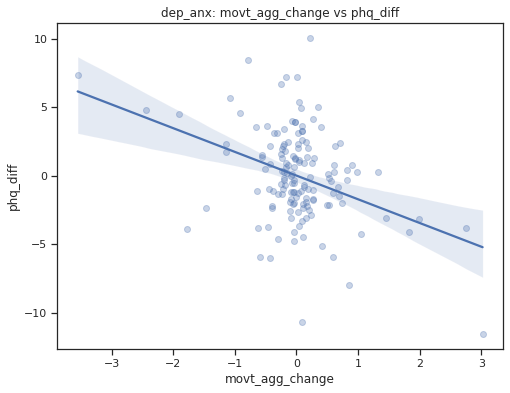

In [50]:
ls_utils.plot_cluster_scatter('movt_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

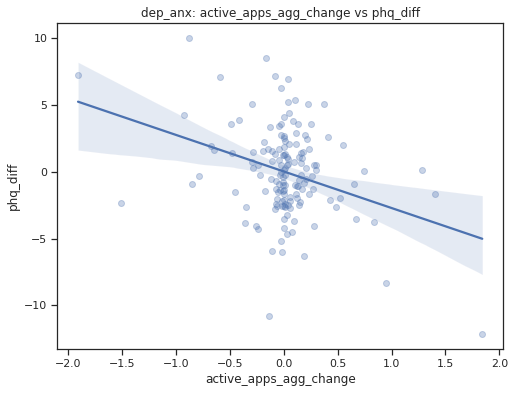

In [51]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

# Reverse PHQ

## Full population

In [52]:
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,814,0,0.9919,0.9919,fdr_bh
1,passive_apps_agg_change,phq_diff,814,-0.021,0.5505,0.8945,fdr_bh
2,social_apps_agg_change,phq_diff,814,-0.045,0.1972,0.4273,fdr_bh
3,work_dur_agg_change,phq_diff,813,-0.064,0.0672*,0.2913,fdr_bh
4,home_dur_agg_change,phq_diff,813,-0.003,0.9355,0.9919,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,813,-0.108,0.0020*,0.0260*,fdr_bh
6,other_dur_agg_change,phq_diff,813,0.027,0.4361,0.8100,fdr_bh
7,social_place_dur_agg_change,phq_diff,813,-0.016,0.6544,0.9452,fdr_bh
8,sms_agg_change,phq_diff,797,-0.072,0.0418*,0.2714,fdr_bh
9,cal_agg_change,phq_diff,798,-0.047,0.1824,0.4273,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,814,-0.005,0.8829,0.9354,fdr_bh
1,passive_apps_agg_change,phq_diff,814,0.003,0.9354,0.9354,fdr_bh
2,social_apps_agg_change,phq_diff,814,-0.014,0.6830,0.9354,fdr_bh
3,work_dur_agg_change,phq_diff,813,-0.057,0.1055,0.6858,fdr_bh
4,home_dur_agg_change,phq_diff,813,-0.012,0.7297,0.9354,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,813,-0.037,0.2859,0.9292,fdr_bh
6,other_dur_agg_change,phq_diff,813,0.043,0.2179,0.9292,fdr_bh
7,social_place_dur_agg_change,phq_diff,813,-0.026,0.4651,0.9354,fdr_bh
8,sms_agg_change,phq_diff,797,-0.008,0.8232,0.9354,fdr_bh
9,cal_agg_change,phq_diff,798,0.01,0.7874,0.9354,fdr_bh


## no_symp

In [53]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,255,-0.103,0.1023,0.3227,fdr_bh
1,passive_apps_agg_change,phq_diff,255,0.043,0.4979,0.7192,fdr_bh
2,social_apps_agg_change,phq_diff,255,0.029,0.6500,0.7845,fdr_bh
3,work_dur_agg_change,phq_diff,254,-0.022,0.7241,0.7845,fdr_bh
4,home_dur_agg_change,phq_diff,254,0.124,0.0480*,0.2628,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,254,-0.097,0.1241,0.3227,fdr_bh
6,other_dur_agg_change,phq_diff,254,0.073,0.2463,0.5112,fdr_bh
7,social_place_dur_agg_change,phq_diff,254,-0.026,0.6843,0.7845,fdr_bh
8,sms_agg_change,phq_diff,252,-0.157,0.0123*,0.1605,fdr_bh
9,cal_agg_change,phq_diff,254,-0.118,0.0606*,0.2628,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,255,-0.114,0.0688*,0.2614,fdr_bh
1,passive_apps_agg_change,phq_diff,255,0.174,0.0054*,0.0699*,fdr_bh
2,social_apps_agg_change,phq_diff,255,0.081,0.1984,0.3684,fdr_bh
3,work_dur_agg_change,phq_diff,254,0.013,0.8356,0.9053,fdr_bh
4,home_dur_agg_change,phq_diff,254,0.11,0.0804*,0.2614,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,254,-0.035,0.5771,0.6820,fdr_bh
6,other_dur_agg_change,phq_diff,254,0.037,0.5580,0.6820,fdr_bh
7,social_place_dur_agg_change,phq_diff,254,-0.006,0.9259,0.9259,fdr_bh
8,sms_agg_change,phq_diff,252,-0.093,0.1427,0.3092,fdr_bh
9,cal_agg_change,phq_diff,254,-0.076,0.2276,0.3698,fdr_bh


## soc_anx

In [54]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,223,-0.025,0.7080,0.9204,fdr_bh
1,passive_apps_agg_change,phq_diff,223,0.01,0.8832,0.9486,fdr_bh
2,social_apps_agg_change,phq_diff,223,-0.013,0.8432,0.9486,fdr_bh
3,work_dur_agg_change,phq_diff,223,-0.047,0.4869,0.9204,fdr_bh
4,home_dur_agg_change,phq_diff,223,-0.044,0.5099,0.9204,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,223,-0.148,0.0275*,0.3570,fdr_bh
6,other_dur_agg_change,phq_diff,223,-0.027,0.6840,0.9204,fdr_bh
7,social_place_dur_agg_change,phq_diff,223,0.078,0.2479,0.8057,fdr_bh
8,sms_agg_change,phq_diff,222,-0.063,0.3464,0.9007,fdr_bh
9,cal_agg_change,phq_diff,219,-0.097,0.1537,0.8057,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,223,-0.064,0.3397,0.7736,fdr_bh
1,passive_apps_agg_change,phq_diff,223,-0.03,0.6528,0.8486,fdr_bh
2,social_apps_agg_change,phq_diff,223,-0.009,0.8888,0.9105,fdr_bh
3,work_dur_agg_change,phq_diff,223,-0.062,0.3571,0.7736,fdr_bh
4,home_dur_agg_change,phq_diff,223,-0.075,0.2638,0.7736,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,223,0.046,0.4939,0.8486,fdr_bh
6,other_dur_agg_change,phq_diff,223,0.092,0.1711,0.7736,fdr_bh
7,social_place_dur_agg_change,phq_diff,223,0.031,0.6463,0.8486,fdr_bh
8,sms_agg_change,phq_diff,222,-0.034,0.6170,0.8486,fdr_bh
9,cal_agg_change,phq_diff,219,-0.008,0.9105,0.9105,fdr_bh


## gen_anx

In [55]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,187,0.012,0.8657,0.9378,fdr_bh
1,passive_apps_agg_change,phq_diff,187,-0.063,0.3900,0.7417,fdr_bh
2,social_apps_agg_change,phq_diff,187,-0.026,0.7197,0.8506,fdr_bh
3,work_dur_agg_change,phq_diff,187,-0.128,0.0807*,0.3815,fdr_bh
4,home_dur_agg_change,phq_diff,187,-0.006,0.9390,0.9390,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,187,-0.109,0.1384,0.3815,fdr_bh
6,other_dur_agg_change,phq_diff,187,0.05,0.4966,0.7417,fdr_bh
7,social_place_dur_agg_change,phq_diff,187,-0.116,0.1138,0.3815,fdr_bh
8,sms_agg_change,phq_diff,180,0.043,0.5705,0.7417,fdr_bh
9,cal_agg_change,phq_diff,184,-0.055,0.4596,0.7417,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,187,0.067,0.3588,0.6663,fdr_bh
1,passive_apps_agg_change,phq_diff,187,-0.016,0.8232,0.9729,fdr_bh
2,social_apps_agg_change,phq_diff,187,0.008,0.9102,0.9850,fdr_bh
3,work_dur_agg_change,phq_diff,187,-0.133,0.0693*,0.6059,fdr_bh
4,home_dur_agg_change,phq_diff,187,0.001,0.9850,0.9850,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,187,-0.123,0.0932*,0.6059,fdr_bh
6,other_dur_agg_change,phq_diff,187,0.082,0.2674,0.6663,fdr_bh
7,social_place_dur_agg_change,phq_diff,187,-0.091,0.2142,0.6663,fdr_bh
8,sms_agg_change,phq_diff,180,0.071,0.3448,0.6663,fdr_bh
9,cal_agg_change,phq_diff,184,0.042,0.5678,0.8201,fdr_bh


## dep_anx

In [56]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,149,0.224,0.0059*,0.0773*,fdr_bh
1,passive_apps_agg_change,phq_diff,149,-0.091,0.2721,0.5750,fdr_bh
2,social_apps_agg_change,phq_diff,149,-0.17,0.0386*,0.1675,fdr_bh
3,work_dur_agg_change,phq_diff,149,-0.044,0.5981,0.7776,fdr_bh
4,home_dur_agg_change,phq_diff,149,-0.127,0.1238,0.4022,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,149,-0.116,0.1603,0.4168,fdr_bh
6,other_dur_agg_change,phq_diff,149,-0.015,0.8517,0.8517,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.018,0.8300,0.8517,fdr_bh
8,sms_agg_change,phq_diff,143,0.028,0.7366,0.8517,fdr_bh
9,cal_agg_change,phq_diff,141,0.086,0.3096,0.5750,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,149,0.163,0.0466*,0.3940,fdr_bh
1,passive_apps_agg_change,phq_diff,149,-0.115,0.1636,0.4874,fdr_bh
2,social_apps_agg_change,phq_diff,149,-0.139,0.0909*,0.3940,fdr_bh
3,work_dur_agg_change,phq_diff,149,-0.049,0.5510,0.7163,fdr_bh
4,home_dur_agg_change,phq_diff,149,-0.102,0.2160,0.4874,fdr_bh
5,religion_exercise_dur_agg_change,phq_diff,149,-0.003,0.9708,0.9708,fdr_bh
6,other_dur_agg_change,phq_diff,149,-0.09,0.2764,0.4874,fdr_bh
7,social_place_dur_agg_change,phq_diff,149,-0.035,0.6751,0.7978,fdr_bh
8,sms_agg_change,phq_diff,143,0.087,0.3000,0.4874,fdr_bh
9,cal_agg_change,phq_diff,141,0.1,0.2396,0.4874,fdr_bh


# Summary Tables of Significant Correlations

## SPIN

In [57]:
ls_utils.build_corr_table(gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'passive app change to SPIN change')

,group,n,r,p-corr,p-adjust
0,all,767,0.104,0.0245384,fdr_bh
1,no_symp,252,0.092,0.703313,fdr_bh
2,soc_anx,202,0.224,0.00898753,fdr_bh
3,gen_anx,175,0.011,0.937505,fdr_bh
4,dep_anx,138,0.144,0.706584,fdr_bh


In [58]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'SPIN change to passive app change')

,group,n,r,p-corr,p-adjust
0,all,764,0.014,0.764509,fdr_bh
1,no_symp,252,0.014,0.835672,fdr_bh
2,soc_anx,201,-0.065,0.635324,fdr_bh
3,gen_anx,174,0.047,0.978067,fdr_bh
4,dep_anx,137,0.075,0.946277,fdr_bh


## GAD

In [59]:
ls_utils.build_corr_table(gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'location PCA change to GAD change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,768,0.1,0.0349619,fdr_bh
1,no_symp,252,0.017,0.814869,fdr_bh
2,soc_anx,202,0.199,0.0586274,fdr_bh
3,gen_anx,176,0.24,0.017024,fdr_bh
4,dep_anx,138,-0.067,0.813675,fdr_bh


In [60]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'GAD change to location PCA change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,764,0.006,0.956911,fdr_bh
1,no_symp,252,0.057,0.904059,fdr_bh
2,soc_anx,201,-0.093,0.496905,fdr_bh
3,gen_anx,174,-0.018,0.887621,fdr_bh
4,dep_anx,137,0.083,0.727715,fdr_bh


## PHQ

In [61]:
ls_utils.build_corr_table(phq_corr, 'fus_pca1_agg_change', agg_cols_change, 'phq_diff', 'location PCA change to PHQ change')

,group,n,r,p-corr,p-adjust


In [62]:
ls_utils.build_corr_table(rev_phq_corr, 'fus_pca1_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to location PCA change')

,group,n,r,p-corr,p-adjust


# Change over Time Periods Analysis

## Functions

In [63]:
def plot_over_time(cols, df, title, study_wks=[4,7,10,13,16], figsize=(8,6)):
    _, ax = plt.subplots(figsize=figsize)
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    

    plt.axhline(y=0, ls='--')
    plt.xlabel("study_wk")
    plt.xticks(study_wks)
    plt.title(title)
    plt.legend()
    
    return plt    

In [64]:
def build_time_corr_df(seq_df, target, feat_cols, study_wks=[4,7,10,13,16]):
    pair_df = pd.DataFrame()
    for idx in study_wks:
        sel_df = seq_df[seq_df['study_wk'] == idx]
        #sel_df = sel_df.dropna(subset=['date'])
        sel_df = sel_df[[target] + feat_cols]
        df = pg.pairwise_corr(sel_df, columns=[feat_cols, [target]], padjust="fdr_bh")
        df['idx'] = idx
        pair_df = pair_df.append(df)
        
    return pair_df

## PHQ

In [65]:
pop_df = build_time_corr_df(phq_corr, 'phq_diff', agg_cols_change)

In [66]:
pop_df[pop_df['X'] == 'movt_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
10,movt_agg_change,phq_diff,150,-0.059,4,0.474521,0.892242,fdr_bh,"[-0.22, 0.1]"
10,movt_agg_change,phq_diff,149,-0.236,7,0.003837,0.049877,fdr_bh,"[-0.38, -0.08]"
10,movt_agg_change,phq_diff,171,-0.120,10,0.116549,0.427542,fdr_bh,"[-0.27, 0.03]"
10,movt_agg_change,phq_diff,172,-0.064,13,0.405787,0.767231,fdr_bh,"[-0.21, 0.09]"
10,movt_agg_change,phq_diff,168,-0.138,16,0.074508,0.396331,fdr_bh,"[-0.28, 0.01]"


(-1, 0.6)

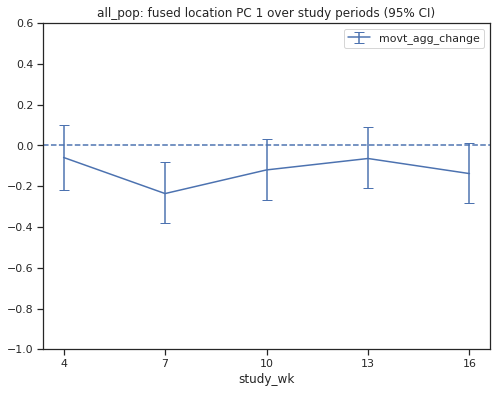

In [67]:
p = plot_over_time(['movt_agg_change'], pop_df, "all_pop: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

In [68]:
dep_anx_df = build_time_corr_df(phq_corr[phq_corr['baseline_cluster'] == 'dep_anx'], 'phq_diff', agg_cols_change)

In [69]:
dep_anx_df[dep_anx_df['X'] == 'movt_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
10,movt_agg_change,phq_diff,28,-0.392,4,0.039147,0.254455,fdr_bh,"[-0.67, -0.02]"
10,movt_agg_change,phq_diff,27,-0.678,7,0.000100,0.001306,fdr_bh,"[-0.84, -0.4]"
10,movt_agg_change,phq_diff,30,-0.342,10,0.064057,0.205191,fdr_bh,"[-0.63, 0.02]"
10,movt_agg_change,phq_diff,31,0.134,13,0.471531,0.875701,fdr_bh,"[-0.23, 0.47]"
10,movt_agg_change,phq_diff,31,-0.352,16,0.051921,0.390185,fdr_bh,"[-0.63, 0.0]"


(-1, 0.6)

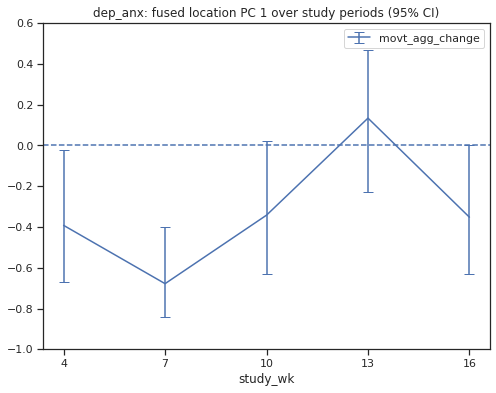

In [70]:
p = plot_over_time(['movt_agg_change'], dep_anx_df, "dep_anx: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

## GAD

In [71]:
gad_df = build_time_corr_df(gad_spin_corr, 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [72]:
gad_df[gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,191,-0.119,"[-0.26, 0.02]",0.014,0.004,-0.120,0.101252,0.490461,fdr_bh,0.343,0.375,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,191,0.079,"[-0.06, 0.22]",0.006,-0.004,0.079,0.274619,0.611613,fdr_bh,0.164,0.194,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,193,-0.023,"[-0.16, 0.12]",0.001,-0.010,-0.023,0.752218,0.966156,fdr_bh,0.095,0.061,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,193,0.054,"[-0.09, 0.19]",0.003,-0.008,0.054,0.456001,0.622138,fdr_bh,0.119,0.116,16


In [73]:
dep_anx_gad_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx'], 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [74]:
dep_anx_gad_df[dep_anx_gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,35,-0.233,"[-0.53, 0.11]",0.054,-0.005,-0.237,0.177243,0.730720,fdr_bh,0.504,0.275,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,34,0.194,"[-0.15, 0.5]",0.038,-0.024,0.196,0.271485,0.582502,fdr_bh,0.381,0.198,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,34,-0.182,"[-0.49, 0.17]",0.033,-0.029,-0.184,0.301913,0.885277,fdr_bh,0.356,0.180,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,35,-0.209,"[-0.51, 0.13]",0.044,-0.016,-0.212,0.227154,0.912945,fdr_bh,0.424,0.229,16


## SPIN

In [75]:
spin_df = build_time_corr_df(gad_spin_corr, 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [76]:
spin_df[spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,191,0.094,7,0.195317,0.883190,fdr_bh,"[-0.05, 0.23]"
1,passive_apps_agg_change,spin_diff,191,0.090,10,0.214940,0.637696,fdr_bh,"[-0.05, 0.23]"
1,passive_apps_agg_change,spin_diff,193,0.130,13,0.072127,0.468826,fdr_bh,"[-0.01, 0.27]"
1,passive_apps_agg_change,spin_diff,192,0.100,16,0.166357,0.454744,fdr_bh,"[-0.04, 0.24]"


(-0.4, 1)

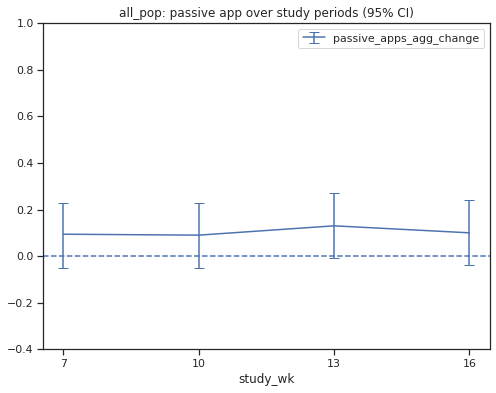

In [77]:
p = plot_over_time(['passive_apps_agg_change'], spin_df, "all_pop: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)

In [78]:
soc_anx_spin_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx'], 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [79]:
soc_anx_spin_df[soc_anx_spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,50,0.222,7,0.121887,0.528176,fdr_bh,"[-0.06, 0.47]"
1,passive_apps_agg_change,spin_diff,50,0.079,10,0.585368,0.951223,fdr_bh,"[-0.2, 0.35]"
1,passive_apps_agg_change,spin_diff,51,0.415,13,0.002470,0.016055,fdr_bh,"[0.16, 0.62]"
1,passive_apps_agg_change,spin_diff,51,0.209,16,0.140599,0.304632,fdr_bh,"[-0.07, 0.46]"


(-0.4, 1)

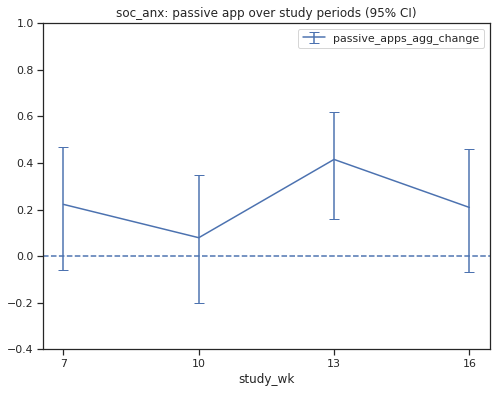

In [80]:
p = plot_over_time(['passive_apps_agg_change'], soc_anx_spin_df, "soc_anx: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)